In [123]:
import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

# First, Let's use the same binomial example as before

In [101]:
data = {'N': 100, 'y': 50} #number of trials, number of successes

In [102]:
def p_data_given_theta(theta, data):
    return theta**data['y'] * (1-theta)**(data['N']-data['y'])

from scipy.stats import beta
def p_theta(theta):
    # beta(1, 1) prior
    return beta.pdf(theta, 1, 1)

def p_data(data, possible_theta_values=np.linspace(0, 1, 1000)):
    """
    This function is the marginal likelihood of the data.
    It is the integral of the likelihood function over possible values of theta, weighted by the prior.
    """
    unweighted_integral = np.sum([p_data_given_theta(theta, data) * p_theta(theta) for theta in possible_theta_values])
    integral = unweighted_integral / np.sum([p_theta(theta) for theta in possible_theta_values])
    return integral

## Let's use grid-sampling, like we did in lecture 2

In [103]:
def grid_sampling(gridnum = 1000):
    possible_theta_values = np.linspace(0, 1, 1000)

    denominator = p_data(data, possible_theta_values)
    p_theta_given_data = [p_data_given_theta(theta, data) * p_theta(theta) / denominator 
                        for theta in possible_theta_values]
    return possible_theta_values, p_theta_given_data

In [104]:
%%timeit
possible_theta_values, p_theta_given_data = grid_sampling(1000)

185 ms ± 4.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


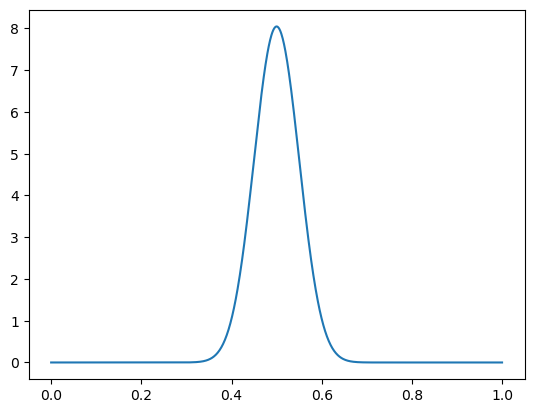

In [105]:
possible_theta_values, p_theta_given_data = grid_sampling(1000)
plt.plot(possible_theta_values, p_theta_given_data)

# rejection sampling

In [106]:
from functools import partial

$ q(\theta | y) \triangleq p(y | \theta) p(\theta)$

In [107]:
def q(theta, data):
    return p_data_given_theta(theta, data) * p_theta(theta)

q_theta_given_data = partial(q, data=data)

In [108]:
# guessing a g function
g_mean = .5
g_std = .1
g = partial(stats.norm.pdf, loc=g_mean, scale=g_std)

In [109]:
## find a big enough M
M = max(q_theta_given_data(theta)/g(theta) for theta in possible_theta_values)
M

1.97730675080858e-31

In [110]:
def accept_sample_prob(theta):
    return q_theta_given_data(theta)/M/g(theta)

def rejection_sampling(num = 1000):
    r1 = stats.norm.rvs(size=num, loc=g_mean, scale=g_std) # sample from g
    accept_probs = [accept_sample_prob(theta) for theta in r1] # compute accept prob
    r2 = np.random.rand(num)
    acc = r2 < accept_probs # accept or reject
    return r1[acc]

In [111]:
nsamples = 1000
acceptedsamples = rejection_sampling(nsamples)

In [112]:
%%timeit
acceptedsamples = rejection_sampling(1000)

120 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [113]:
print(f'Effective Sampling Size: {len(acceptedsamples)} out of {nsamples} samples')

Effective Sampling Size: 540 out of 1000 samples


<AxesSubplot: ylabel='Count'>

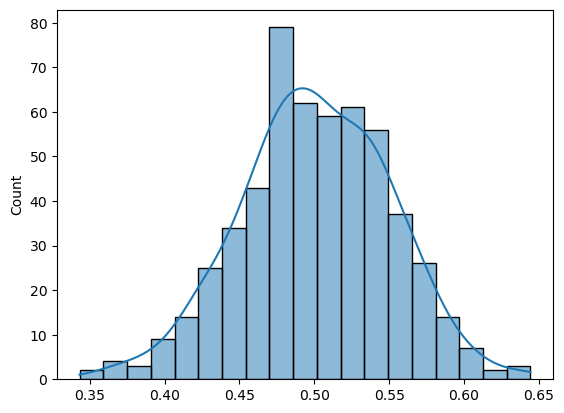

In [114]:
sns.histplot(acceptedsamples, kde=True)

# 2d Normal example

In [115]:
true_mu = .3
true_sigma = .1

In [116]:
N = 100
y = np.random.normal(true_mu, true_sigma, N)
data = {'N': N, 'y': y} 

In [132]:
y

array([0.23796305, 0.42602963, 0.23349654, 0.34936795, 0.22150558,
       0.2531058 , 0.33041754, 0.47248852, 0.20619763, 0.18125609,
       0.28894216, 0.2787963 , 0.42002483, 0.39930685, 0.35396293,
       0.39853191, 0.51709883, 0.19758974, 0.17662916, 0.28373991,
       0.2111826 , 0.25237443, 0.41065837, 0.33890707, 0.34128783,
       0.30812716, 0.2930302 , 0.17329101, 0.21884179, 0.47669854,
       0.16616491, 0.24710494, 0.33766473, 0.48884298, 0.36360031,
       0.46818172, 0.27695894, 0.27461645, 0.284149  , 0.15702215,
       0.41228165, 0.24665735, 0.26020862, 0.10971366, 0.40708792,
       0.31724566, 0.21461813, 0.26944364, 0.1680146 , 0.36299762,
       0.40232778, 0.34172552, 0.31282175, 0.25510922, 0.39911014,
       0.41469229, 0.43961287, 0.18762515, 0.24359071, 0.33046729,
       0.49179356, 0.17758285, 0.36987333, 0.36434286, 0.33392637,
       0.2211087 , 0.34068777, 0.34290203, 0.31753672, 0.19501801,
       0.45827754, 0.36677198, 0.38774716, 0.46851478, 0.39152

In [117]:
# prior uniform 0, 1
def p_theta(theta):
    return 1

In [126]:
from scipy.stats import norm
def p_data_given_theta(theta, data):
    mu, sigma = theta
    ys = data['y']
    return np.exp(sum([np.log(norm.pdf(y, mu, sigma)) for y in ys]))

def p_data(data, possible_theta_values):
    """
    This function is the marginal likelihood of the data.
    It is the integral of the likelihood function over possible values of theta, weighted by the prior.
    """
    unweighted_integral = np.sum([p_data_given_theta(theta, data) * p_theta(theta) for theta in possible_theta_values])
    integral = unweighted_integral / np.sum([p_theta(theta) for theta in possible_theta_values])
    return integral

Grid sampling

In [133]:
def grid_sampling(gridnum = 1000):
    possible_mu_values = np.linspace(0.01, 1, gridnum)
    possible_sigma_values = np.linspace(0.01, 1, gridnum)
    possible_theta_values = [(mu, sigma) for mu in possible_mu_values for sigma in possible_sigma_values]

    denominator = p_data(data, possible_theta_values)
    p_theta_given_data = [p_data_given_theta(theta, data) * p_theta(theta) / denominator 
                        for theta in possible_theta_values]
    return possible_theta_values, p_theta_given_data

In [142]:
possible_theta_values, p_theta_given_data = grid_sampling(30)

/tmp/ipykernel_5623/3057499042.py:5: RuntimeWarning: divide by zero encountered in log
  return np.exp(sum([np.log(norm.pdf(y, mu, sigma)) for y in ys]))


In [143]:
df = pd.DataFrame(possible_theta_values, columns=['mu', 'sigma'])
df['p_theta_given_data'] = p_theta_given_data

/tmp/ipykernel_5623/1009767289.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(df.pivot('mu', 'sigma', 'p_theta_given_data'), norm=LogNorm())


<AxesSubplot: xlabel='sigma', ylabel='mu'>

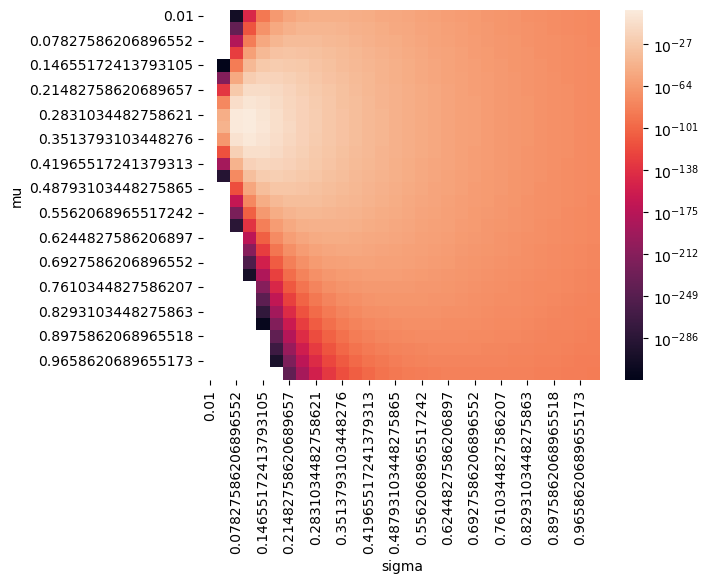

In [144]:
from matplotlib.colors import LogNorm, Normalize

sns.heatmap(df.pivot('mu', 'sigma', 'p_theta_given_data'), norm=LogNorm())

Rejections sampling --- not working at the moment

In [149]:
def q(theta, data):
    return p_data_given_theta(theta, data) * p_theta(theta)

In [169]:
# guessing a g function
g_mean = .5
g_std = .2
g_var = g_std**2

from scipy.stats import multivariate_normal
def g(theta):
    return multivariate_normal.pdf([theta[0], theta[1]], mean=[g_mean, g_mean], cov=np.diag([g_var, g_var]))
    # mu, sigma = theta
    # pmu = stats.norm.pdf(mu, loc=g_mean, scale=g_std)
    # psigma = 1
    # return pmu * psigma

q_theta_given_data = partial(q, data=data)

## find a big enough M
M= max([q_theta_given_data(theta)/g(theta) for theta in possible_theta_values])
M

/tmp/ipykernel_5623/3057499042.py:5: RuntimeWarning: divide by zero encountered in log
  return np.exp(sum([np.log(norm.pdf(y, mu, sigma)) for y in ys]))


2.2290242582910555e+39

In [170]:
def accept_sample_prob(theta):
    return q_theta_given_data(theta)/M/g(theta)

def rejection_sampling(num = 1000):
    # sample from g
    mu = stats.norm.rvs(size=num, loc=g_mean, scale=g_std)
    sigma = np.random.rand(num)
    r1 = np.array(list(zip(mu, sigma)))    
    accept_probs = [accept_sample_prob(theta) for theta in r1] # compute accept prob
    r2 = np.random.rand(num)
    acc = r2 < accept_probs # accept or reject
    return r1[acc]
nsamples = 1000
acceptedsamples = rejection_sampling(nsamples)


/tmp/ipykernel_5623/3057499042.py:5: RuntimeWarning: divide by zero encountered in log
  return np.exp(sum([np.log(norm.pdf(y, mu, sigma)) for y in ys]))


In [171]:
acceptedsamples

array([[0.2978386 , 0.09295809],
       [0.32943513, 0.08705815],
       [0.30151064, 0.10400171]])

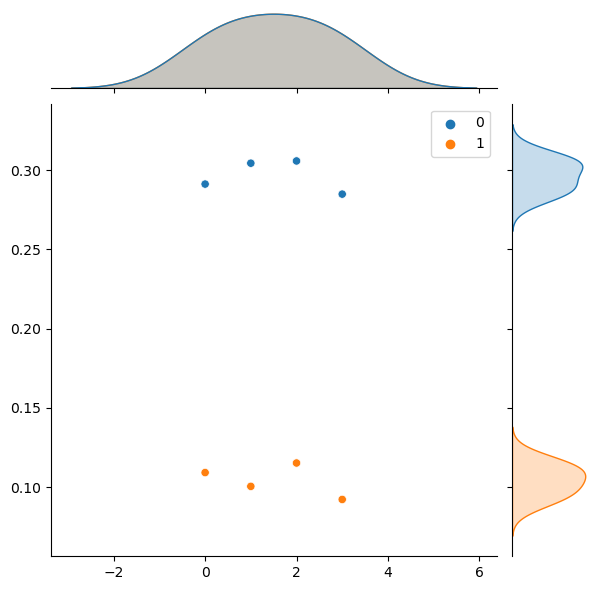

In [166]:
sns.jointplot(acceptedsamples)

In [172]:
# %%timeit
# acceptedsamples = rejection_sampling(1000)
# print(f'Effective Sampling Size: {len(acceptedsamples)} out of {nsamples} samples')

## gibbs sampling

In [173]:
def sample_mu_given_sigma_data(sigma, data):
    pass